# Assignment 2: Convolutional Neural Networks
Instructions: In Assignment 2, you will learn all about the convolutional neural networks. In particular, you will gain a first-hand experience of the training process, understand the architectural details, and familiarize with transfer learning
with deep networks.

In [43]:
!pip uninstall torch torchvision torchaudio
!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

^C
^C


In [1]:
pip install --upgrade jupyter notebook


     -------------------------------------- 529.8/529.8 kB 2.4 MB/s eta 0:00:00
  Attempting uninstall: notebook
    Found existing installation: notebook 6.5.2
    Uninstalling notebook-6.5.2:
      Successfully uninstalled notebook-6.5.2
  Attempting uninstall: jupyter
    Found existing installation: jupyter 1.0.0
    Uninstalling jupyter-1.0.0:
      Successfully uninstalled jupyter-1.0.0
Note: you may need to restart the kernel to use updated packages.


## Part 1: Convolutional Neural Networks
In this part, you will experiment with a convolutional neural network implementation to perform image classification. The dataset we will use for this assignment was created by Zoya Bylinskii, and contains 451 works of art from 11 different artists all downsampled and padded to the same size. The task is to identify which artist produced each image. The original images can be found in the `art_data/artists` directory included with the data zip file. The composition of the dataset and a sample painting from each artist are shown in Table 1.

Figure 1 shows an example of the type of convolutional architecture typically employed for similar image recognition problems. Convolutional layers apply filters to the image, and produce layers of
feature maps. Often, the convolutional layers are interspersed with pooling layers. The final layers of the network are fully connected, and lead to an output layer with one node for each of the K classes
the network is trying to detect. We will use a similar architecture for our network.

![](figures/figure1.jpg)

The code for performing the data processing and training the network is provided in the starter
pack. You will use PyTorch to implement convolutional neural networks. We create a dataset from the artists’ images by downsampling them to 50x50 pixels, and transforming the RGB values to lie within the range $[-0.5, 0.5]$. We provide a lot of starter code below, but you will need to modify the hyperparameters and network structure.

### Part 1.1: Convolutional Filter Receptive Field

First, it is important to develop an intuition for how a convolutional layer affects the feature representations that the network learns. Assume that you have a network in which the first convolutional layer
applies a 5x5 patch to the image, producing a feature map $Z_{1}$. The next layer of the network is also convolutional; in this case, a 3x3 patch is applied to the feature map $Z_{1}$ to produce a new feature
map, $Z_{2}$. Assume the stride used in both cases is 1. Let the receptive field of a node in this network be the portion of the original image that contributes information to the node (that it can, through the filters of the network, “see”). What are the dimensions of the receptive field for a node in $Z_{2}$? Note that you can ignore padding, and just consider patches in the middle of the image and $Z_{1}$. Thinking about your answer, why is it effective to build convolutional networks deeper, i.e. with more layers?

In [ ]:
#Q1
#First layer Z1 corresponds to 5x5 from imput image
#each node in Z2 corresponds to a 3x3 patch in Z1
# For the size of receptive field for a node in Z2 is 5+3-1=7x7
#Q2
#Adding layers increses the receptive field expontially which allows the network
#to capture larger context
#Shallow layered networks learn low-lever features like edges and textures while
#deeper layers learn more abstract features
#Each layer introduces more non-linearities ( by using activation functions)

### Part 1.2: Run the PyTorch ConvNet

Study the provided SimpleCNN class below, and take a look at the hyperparameters. Answer the following questions about the initial implementation:

1) How many layers are there? Are they all convolutional? If not, what structure do they have?
2) Which activation function is used on the hidden nodes?
3) What loss function is being used to train the network?
4) How is the loss being minimized?

# q1
There are 2 conv, 2 pooling, 2 fully connected layer

conv_layer1 is a convolutional layer with 16 filters with the size of 5x5 and stride 2
conv_layer2 is a convolutional layer with 16 filters with the size of 5x5 and stride 2

pool_layer1: max pooling layer with a 2x2 kernel and 2 stride
pool_layer2: same with pool_layer1

fully_connected_layer has 64 neuron when pooling is enabled, otherwise 1600
final_layer has 11 output nerons which represents each artist class

no some layers are max-pooling layers or fully connected layers
# Q2
def forward(self,inp):
        x = torch.nn.functional.relu(self.conv_layer1(inp))
        if self.pooling:
            x = self.pool_layer1(x)
        x = torch.nn.functional.relu(self.conv_layer2(x))
        if self.pooling:
            x = self.pool_layer2(x)
        x = x.reshape(x.size(0),-1)
        x = torch.nn.functional.relu(self.fully_connected_layer(x))
        x = self.final_layer(x)
        return x
  As it seen ReLu used
  
# Q3
crossentropyloss is being used
# Q4
loss is minimized via adam optimizer



Now that you are familiar with the code, try training the network. It should take between 60-120 seconds to train for 50 epochs. What is the training accuracy for your network after training? What is the validation accuracy? What do these two numbers tell you about what your network is doing?

In [ ]:
#Training ended returning the best model
#Best val acc: 0.4945054945054945, Best val loss: 2.0458802382151284, Best train acc: 0.6722222222222223, Best train loss: 1.8826509869616965 
# There is a gap between training accuracy and validation accuracy. This is because 
#of the overfitting the training data and is not generalizing well

In [2]:
pip install torchvision


Note: you may need to restart the kernel to use updated packages.


In [3]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from PIL import Image, ImageFile
import tqdm
from torch.nn import CrossEntropyLoss
import time
import random
from torchvision import transforms, utils
import numpy as np
import os
from torch import optim

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)
# device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")

cuda


In [4]:
class SimpleCNN(torch.nn.Module):
    def __init__(self,device,pooling= False):
        super(SimpleCNN, self).__init__()
        self.device = device
        self.pooling = pooling
        self.conv_layer1 =  torch.nn.Conv2d(in_channels=3,out_channels=16,kernel_size=5,stride=2, device=device)
        self.pool_layer1 = torch.nn.MaxPool2d(kernel_size=2,stride=2)
        self.conv_layer2 = torch.nn.Conv2d(in_channels=16,out_channels=16,kernel_size=5,stride=2, device=device)
        self.pool_layer2 = torch.nn.MaxPool2d(kernel_size=2,stride=2)
        if pooling:
            self.fully_connected_layer = nn.Linear(64,64, device=device)
            self.final_layer = nn.Linear(64,11, device=device)
        else:
            self.fully_connected_layer = nn.Linear(1600, 64, device=device)
            self.final_layer = nn.Linear(64, 11, device=device)
    def forward(self,inp):
        x = torch.nn.functional.relu(self.conv_layer1(inp))
        if self.pooling:
            x = self.pool_layer1(x)
        x = torch.nn.functional.relu(self.conv_layer2(x))
        if self.pooling:
            x = self.pool_layer2(x)
        x = x.reshape(x.size(0),-1)
        x = torch.nn.functional.relu(self.fully_connected_layer(x))
        x = self.final_layer(x)
        return x

In [5]:
class LoaderClass(Dataset):
    def __init__(self,data,labels,phase,transforms):
        super(LoaderClass, self).__init__()
        self.transforms = transforms
        self.labels = labels[phase + "_labels"]
        self.data = data[phase + "_data"]
        self.phase = phase

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        label = self.labels[idx]
        img = self.data[idx]
        img = Image.fromarray(img)
        img = self.transforms(img)
        return img,torch.from_numpy(label)

In [6]:
class Trainer():
    def __init__(self,model,criterion,tr_loader,val_loader,optimizer,
                 num_epoch,patience,batch_size,lr_scheduler=None):
        self.model = model
        self.tr_loader = tr_loader
        self.val_loader = val_loader
        self.optimizer = optimizer
        self.num_epoch = num_epoch
        self.patience = patience
        self.lr_scheduler = lr_scheduler
        self.criterion = criterion
        self.softmax = nn.Softmax()
        self.no_inc = 0
        self.best_loss = 9999
        self.phases = ["train","val"]
        self.best_model = []
        self.best_val_acc = 0
        self.best_train_acc = 0
        self.best_val_loss = 0
        self.best_train_loss = 0
        self.batch_size = batch_size

        pass
    def train(self):
        pbar = tqdm.tqdm(desc= "Epoch 0, phase: Train",postfix="train_loss : ?, train_acc: ?")
        for i in range(self.num_epoch):
            last_train_acc = 0
            last_val_acc = 0
            last_val_loss = 0
            last_train_loss = 0
            pbar.update(1)

            for phase in self.phases:
                total_acc = 0
                total_loss = 0
                start = time.time()
                if phase == "train":
                    pbar.set_description_str("Epoch %d,"% i + "phase: Training")
                    loader = self.tr_loader
                    self.model.train()
                else:
                    pbar.set_description_str("Epoch %d,"% i + "phase: Validation")
                    loader = self.val_loader
                    self.model.eval()
                iter = 0
                for images,labels in loader:
                    iter += 1
                    images = images.to(self.model.device)
                    labels = labels.to(self.model.device)
                    self.optimizer.zero_grad()
                    logits = self.model(images)
                    softmaxed_scores = self.softmax(logits)
                    _, predictions = torch.max(softmaxed_scores,1)
                    _, labels = torch.max(labels,1)
                    loss = self.criterion(softmaxed_scores.float(),labels.long())
                    total_loss += loss.item()
                    total_acc += torch.sum(predictions == labels).item()

                    if phase == "train":
                        pbar.set_postfix_str("train acc: %6.3f," %(total_acc/ (iter*self.batch_size)) + ("train loss: %6.3f" % (total_loss / iter)))
                        loss.backward()
                        self.optimizer.step()
                    else:
                        pbar.set_postfix_str("val acc: %6.3f," %(total_acc/ (iter*self.batch_size)) + ("val loss: %6.3f" % (total_loss / iter)))


                if phase == "train":
                    if self.lr_scheduler:

                        self.lr_scheduler.step()
                end = time.time()
                if phase == "train":
                    loss_p = total_loss / iter
                    acc_p = total_acc / len(self.tr_loader.dataset)
                    last_train_acc = acc_p
                    last_train_loss = loss_p
                else:
                    loss_p = total_loss / iter
                    acc_p = total_acc / len(self.val_loader.dataset)
                    last_val_acc = acc_p
                    last_val_loss = loss_p

                    if loss_p < self.best_loss:
                        print("New best loss, loss is: ",str(loss_p), "acc is: ",acc_p )
                        self.best_loss = loss_p
                        self.no_inc = 0
                        self.best_model = self.model
                        self.best_train_acc = last_train_acc
                        self.best_train_loss = last_train_loss
                        self.best_val_loss = last_val_loss
                        self.best_val_acc = last_val_acc
                    else:
                        print("Not a better score")


                        self.no_inc += 1
                        if self.no_inc == self.patience:
                            print("Out of patience returning the best model")
                            print(
                                "Best val acc: {}, Best val loss: {}, Best train acc: {}, Best train loss: {} ".format(
                                    self.best_val_acc, self.best_val_loss, self.best_train_acc, self.best_train_loss
                                ))  # Stats of the best model
                            return self.best_model
        print("Training ended returning the best model")
        print(
            "Best val acc: {}, Best val loss: {}, Best train acc: {}, Best train loss: {} ".format(
                self.best_val_acc, self.best_val_loss, self.best_train_acc, self.best_train_loss
            ))  # Stats of the best model
        return self.best_model

In [7]:
LR = 1e-4
Momentum = 0.9 # If you use SGD with momentum
BATCH_SIZE = 16
POOLING = False
NUM_EPOCHS = 200
PATIENCE = 30
TRAIN_PERCENT = 0.8
VAL_PERCENT = 0.2
NUM_ARTISTS = 11
DATA_PATH = "./art_data/artists"
ImageFile.LOAD_TRUNCATED_IMAGES = True # Do not change this

In [8]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

In [9]:
def load_artist_data():
    data = []
    labels = []
    artists = [x for x in os.listdir(DATA_PATH) if x != '.DS_Store']
    print(artists)
    for folder in os.listdir(DATA_PATH):
        class_index = artists.index(folder)
        for image_name in os.listdir(DATA_PATH + "/" + folder):
            img = Image.open(DATA_PATH + "/" + folder + "/" + image_name)
            artist_label = (np.arange(NUM_ARTISTS) == class_index).astype(np.float32)
            data.append(np.array(img))
            labels.append(artist_label)
    shuffler = np.random.permutation(len(labels))
    data = np.array(data)[shuffler]
    labels = np.array(labels)[shuffler]

    length = len(data)
    val_size = int(length*0.2)
    val_data = data[0:val_size+1]
    train_data = data[val_size+1::]
    val_labels = labels[0:val_size+1]
    train_labels = labels[val_size+1::]
    print(val_labels)
    data_dict = {"train_data":train_data,"val_data":val_data}
    label_dict = {"train_labels":np.array(train_labels),"val_labels":np.array(val_labels)}

    return data_dict,label_dict

In [10]:
seed_everything(42)
data,labels = load_artist_data()
model = SimpleCNN(device=device,pooling=False)
optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-4)
transform = {
    'train': transforms.Compose([
        transforms.Resize(50),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(50),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    }

['canaletto', 'claude monet', 'george romney', 'j. m. w. turner', 'john robert cozens', 'paul cezanne', 'paul gauguin', 'paul sandby', 'peter paul rubens', 'rembrandt', 'richard wilson']
[[0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 1. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]]


In [11]:
train_dataset = LoaderClass(data,labels,"train",transform["train"])
valid_dataset = LoaderClass(data,labels,"val",transform["val"])
train_loader = torch.utils.data.DataLoader(train_dataset,
                                               batch_size=BATCH_SIZE,
                                               shuffle=True, num_workers=0, pin_memory=True)
val_loader = torch.utils.data.DataLoader(valid_dataset,
                                             batch_size=BATCH_SIZE,
                                             shuffle=True, num_workers=0, pin_memory=True)


In [12]:
criterion = CrossEntropyLoss()
trainer_m = Trainer(model, criterion, train_loader, val_loader, optimizer, num_epoch=NUM_EPOCHS, patience=PATIENCE,batch_size=BATCH_SIZE,lr_scheduler= None)
best_model = trainer_m.train()

Epoch 0,phase: Training: 1it [00:00, ?it/s, train_loss : ?, train_acc: ?]C:\Users\arday\anaconda3\envs\comp541\lib\site-packages\ipykernel_launcher.py:52: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
Epoch 1,phase: Training: 2it [00:00,  3.45it/s, train acc:  0.347,train loss:  2.379]  

New best loss, loss is:  2.3851243257522583 acc is:  0.3516483516483517


Epoch 2,phase: Training: 3it [00:01,  2.60it/s, train acc:  0.333,train loss:  2.253]  

New best loss, loss is:  2.28770120938619 acc is:  0.31868131868131866


Epoch 3,phase: Training: 4it [00:01,  2.17it/s, train acc:  0.358,train loss:  2.169]  

New best loss, loss is:  2.187334656715393 acc is:  0.34065934065934067


Epoch 4,phase: Training: 5it [00:02,  2.13it/s, train acc:  0.444,train loss:  2.115]  

Not a better score


Epoch 5,phase: Training: 6it [00:02,  2.10it/s, train acc:  0.464,train loss:  2.097]  

New best loss, loss is:  2.1770418286323547 acc is:  0.34065934065934067


Epoch 6,phase: Training: 7it [00:03,  2.10it/s, train acc:  0.455,train loss:  2.065]  

Not a better score


Epoch 7,phase: Training: 8it [00:03,  2.13it/s, train acc:  0.490,train loss:  2.043]  

New best loss, loss is:  2.1708605686823526 acc is:  0.3516483516483517


Epoch 8,phase: Training: 9it [00:04,  2.16it/s, train acc:  0.489,train loss:  2.064]  

New best loss, loss is:  2.1686359643936157 acc is:  0.3626373626373626


Epoch 9,phase: Training: 10it [00:04,  2.14it/s, train acc:  0.574,train loss:  1.988] 

Not a better score


Epoch 10,phase: Training: 11it [00:05,  2.15it/s, train acc:  0.517,train loss:  2.027] 

New best loss, loss is:  2.148403743902842 acc is:  0.37362637362637363


Epoch 11,phase: Training: 12it [00:05,  2.09it/s, train acc:  0.521,train loss:  2.032]  

Not a better score


Epoch 12,phase: Training: 13it [00:06,  2.04it/s, train acc:  0.600,train loss:  1.962]  

Not a better score


Epoch 13,phase: Training: 14it [00:06,  1.98it/s, train acc:  0.611,train loss:  1.974]  

New best loss, loss is:  2.1379536588986716 acc is:  0.38461538461538464


Epoch 14,phase: Training: 15it [00:07,  1.97it/s, train acc:  0.580,train loss:  1.992]  

Not a better score


Epoch 15,phase: Training: 16it [00:07,  2.04it/s, train acc:  0.574,train loss:  1.988]  

Not a better score


Epoch 16,phase: Training: 17it [00:08,  2.08it/s, train acc:  0.615,train loss:  1.960]  

Not a better score


Epoch 17,phase: Training: 18it [00:08,  2.09it/s, train acc:  0.597,train loss:  1.960]  

New best loss, loss is:  2.120197594165802 acc is:  0.37362637362637363


Epoch 18,phase: Training: 19it [00:09,  2.02it/s, train acc:  0.549,train loss:  1.997]  

Not a better score


Epoch 19,phase: Training: 20it [00:09,  1.97it/s, train acc:  0.562,train loss:  1.996]  

Not a better score


Epoch 20,phase: Training: 21it [00:10,  1.97it/s, train acc:  0.555,train loss:  1.996]  

Not a better score


Epoch 21,phase: Training: 22it [00:10,  1.83it/s, train acc:  0.516,train loss:  2.028]  

Not a better score


Epoch 22,phase: Training: 23it [00:11,  1.72it/s, train acc:  0.594,train loss:  1.950]  

Not a better score


Epoch 23,phase: Training: 24it [00:12,  1.68it/s, train acc:  0.636,train loss:  1.941]  

Not a better score


Epoch 24,phase: Training: 25it [00:12,  1.76it/s, train acc:  0.631,train loss:  1.931]  

Not a better score


Epoch 25,phase: Training: 26it [00:13,  1.81it/s, train acc:  0.608,train loss:  1.952]  

Not a better score


Epoch 26,phase: Training: 27it [00:13,  1.87it/s, train acc:  0.631,train loss:  1.937]  

Not a better score


Epoch 27,phase: Training: 28it [00:14,  1.91it/s, train acc:  0.619,train loss:  1.938]  

Not a better score


Epoch 28,phase: Training: 29it [00:14,  1.89it/s, train acc:  0.650,train loss:  1.918]  

Not a better score


Epoch 29,phase: Training: 30it [00:15,  1.80it/s, train acc:  0.606,train loss:  1.944]  

Not a better score


Epoch 30,phase: Training: 31it [00:15,  1.74it/s, train acc:  0.602,train loss:  1.944]  

Not a better score


Epoch 31,phase: Training: 32it [00:16,  1.64it/s, train acc:  0.634,train loss:  1.920]  

Not a better score


Epoch 32,phase: Training: 33it [00:17,  1.57it/s, train acc:  0.611,train loss:  1.941]  

Not a better score


Epoch 33,phase: Training: 34it [00:17,  1.60it/s, train acc:  0.625,train loss:  1.938]  

Not a better score


Epoch 34,phase: Training: 35it [00:18,  1.54it/s, train acc:  0.705,train loss:  1.860]  

Not a better score


Epoch 35,phase: Training: 36it [00:19,  1.52it/s, train acc:  0.672,train loss:  1.891]  

Not a better score


Epoch 36,phase: Training: 37it [00:19,  1.50it/s, train acc:  0.688,train loss:  1.871]  

Not a better score


Epoch 37,phase: Training: 38it [00:20,  1.45it/s, train acc:  0.695,train loss:  1.861]  

Not a better score


Epoch 38,phase: Training: 39it [00:21,  1.48it/s, train acc:  0.625,train loss:  1.922]  

Not a better score


Epoch 39,phase: Training: 40it [00:21,  1.54it/s, train acc:  0.727,train loss:  1.832]  

Not a better score


Epoch 40,phase: Training: 41it [00:22,  1.57it/s, train acc:  0.700,train loss:  1.859]  

Not a better score


Epoch 41,phase: Training: 42it [00:23,  1.60it/s, train acc:  0.648,train loss:  1.902]  

Not a better score


Epoch 42,phase: Training: 43it [00:23,  1.65it/s, train acc:  0.688,train loss:  1.873]  

Not a better score


Epoch 43,phase: Training: 44it [00:24,  1.75it/s, train acc:  0.665,train loss:  1.885]  

Not a better score


Epoch 44,phase: Training: 45it [00:24,  1.83it/s, train acc:  0.662,train loss:  1.895]  

Not a better score


Epoch 45,phase: Training: 46it [00:25,  1.91it/s, train acc:  0.698,train loss:  1.852]  

Not a better score


Epoch 46,phase: Training: 47it [00:25,  1.95it/s, train acc:  0.706,train loss:  1.851]  

Not a better score


Epoch 46,phase: Validation: 47it [00:26,  1.80it/s, val acc:  0.354,val loss:  2.134]    

Not a better score
Out of patience returning the best model
Best val acc: 0.37362637362637363, Best val loss: 2.120197594165802, Best train acc: 0.5833333333333334, Best train loss: 1.9818794001703677 


### Part 1.3: Add Pooling Layers
We will now add max pooling layers after each of our convolutional layers. This code has already been provided for you; all you need to do is switch the pooling flag in the hyper-parameters to True,
and choose different values for the pooling filter size and stride. After you applied max pooling, what happened to your results? How did the training accuracy vs. validation accuracy change? What does
that tell you about the effect of max pooling on your network?

#q1
No significant impact on validation accuracy neither training accuracy
#q2
#Best val acc: 0.4945054945054945, Best val loss: 2.0458802382151284, Best train acc: 0.6722222222222223, Best train loss: 1.8826509869616965 
#q3 It didnt change anything


### Part 1.4: Regularize Your Network!
Because this is such a small dataset, your network is likely to overfit the data. Implement the following ways of regularizing your network. Test each one individually, and discuss how it affects your results.

- __Dropout__: In PyTorch, this is implemented using the `torch.nn.dropout` class, which takes a value called the `keep_prob`, representing the probability that an activation will be dropped out. This value should be between 0.1 and 0.5 during training, and 0 for evaluation and testing. An example of how this works is available here. You should add this to your network and try different values to find one that works well.

- __Weight Regularization__: You should try different optimizers, and different weight decay values for optimizers.

- __Early Stopping__: Stop training your model after your validation accuracy starts to plateau or decrease (so you do not overtrain your model). The number of steps can be controlled through the `patience` hyperparameter in the code.

- __Learning Rate Scheduling__: Learning rate scheduling is an important part of training neural networks. There are a lot of techniques for learning rate scheduling. You should try
different schedulers such as `StepLR`, `CosineAnnealing`, etc.

Give your results for each of these regularization techniques, and discuss which ones were the most effective.

#my network's result without the regularizing:
#Best val acc: 0.4945054945054945, Best val loss: 2.0458802382151284, Best train acc: 0.6722222222222223, Best train loss: 1.8826509869616965 

#Dropout without max-pooling:
#Best val acc: 0.46153846153846156, Best val loss: 2.0580704609553018, Best train acc: 0.6361111111111111, Best train loss: 1.911799871403238 

#Dropout with max-pooling:
#Best val acc: 0.46153846153846156, Best val loss: 2.0580704609553018, Best train acc: 0.6361111111111111, Best train loss: 1.911799871403238

#Weight regularization with optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
#Best val acc: 0.4945054945054945, Best val loss: 2.0458802382151284, Best train acc: 0.6722222222222223, Best train loss: 1.8826509869616965

#weignht regularization with sgd:
#Best val acc: 0.10989010989010989, Best val loss: 2.394560217857361, Best train acc: 0.17222222222222222, Best train loss: 2.3935634986214014

#with early stopping
#Best val acc: 0.4945054945054945, Best val loss: 2.0458802382151284, Best train acc: 0.6722222222222223, Best train loss: 1.8826509869616965

#with cosineAnnealingLR:
#Best val acc: 0.43956043956043955, Best val loss: 2.077328105767568, Best train acc: 0.6361111111111111, Best train loss: 1.9213742484217105 

#with LRstep
#Best val acc: 0.46153846153846156, Best val loss: 2.074002742767334, Best train acc: 0.6583333333333333, Best train loss: 1.9027296874834143 

### Part 1.5: Experiment with Your Architecture

All those parameters at the top of `SimpleCNN` still need to be set. You cannot possibly explore all combinations; so try to change some of them individually to get some feeling for their effect (if any).
Optionally, you can explore adding more layers. Report which changes led to the biggest increases and decreases in performance. In particular, what is the effect of making the convolutional layers have (a) a larger filter size, (b) a larger stride and (c) greater depth? How does a pyramidal-shaped network in which the feature maps gradually decrease in height and width but increase in depth compare to a flat architecture, or one with the opposite shape?


PART A.
-Original CNN's score was : #Best val acc: 0.4945054945054945, Best val loss: 2.0458802382151284, Best train acc: 0.6722222222222223, Best train loss: 1.8826509869616965

-CNN with 7X7 kernel:Best val acc: 0.45054945054945056, Best val loss: 2.0870609482129416, Best train acc: 0.7055555555555556, Best train loss: 1.8399030384810076 

-CNN with 3x3 kernel:  Best val acc: 0.4835164835164835, Best val loss: 2.0581679145495095, Best train acc: 0.6944444444444444, Best train loss: 1.865841673768085 

Explanation: Increasing the filter size leds convolutional layers to capture more spatial information

PART B.
-Original CNN's score was : #Best val acc: 0.4945054945054945, Best val loss: 2.0458802382151284, Best train acc: 0.6722222222222223, Best train loss: 1.8826509869616965
-CNN with 1 stride: Best val acc: 0.5054945054945055, Best val loss: 2.0285547176996865, Best train acc: 0.8, Best train loss: 1.7499474857164465
-CNN with 3 stride: Best val acc: 0.46153846153846156, Best val loss: 2.0801389813423157, Best train acc: 0.6833333333333333, Best train loss: 1.8721903666206028 

Explanation: Increasing stride causes reduces the size of feature maps. So it effects accuracy bad

PART C:
-Original CNN's score was : #Best val acc: 0.4945054945054945, Best val loss: 2.0458802382151284, Best train acc: 0.6722222222222223, Best train loss: 1.8826509869616965

-CNN with 3rd conv layer: Best val acc: 0.38461538461538464, Best val loss: 2.1207900047302246, Best train acc: 0.5444444444444444, Best train loss: 2.014125969098962

Explanaiton: Normall adding an another layer increase the capacity of the network but in my example my performance is decreased.

In pyramidal-shaped network feature maps decreases spatial dimensions but increases the depth
This is much more efficient that inverted architecture because:
1. Feature Hierarchy: It captures deatils in the low level layers.
2. Efficiency:It decreses the cost of the computation

### Part 1.6: Optimize Your Architecture
Based on your experience with these tests, try to achieve the best performance that you can on the validation set by varying the hyperparameters, architecture, and regularization methods. You can even (optionally) try to think of additional ways to augment the data, or experiment with techniques like local response normalization layers using `torch.nn.LocalResponseNorm` or weight normalization using the implementation [here](https://pytorch.org/docs/stable/_modules/torch/nn/utils/weight_norm.html#weight_norm). Report the best performance you are able to achieve, and the settings you used to obtain it.

My best result was:
Best val acc: 0.5824175824175825, Best val loss: 2.333016554514567, Best train acc: 0.9, Best train loss: 2.290077966192494 
I used
    -7 kernels with 1 stride.
    -I used AdamW optimizer
    -I added 3rd Layer
    -I added a softmax layer in the final activation
    -I used dropout
    -I used batch normalization


### Part 1.7: Test Your Final Architecture on Variations of the Data
In PyTorch data augmentation can be done dynamically while loading the data using what they call `transforms`. Note that some of the transforms are already implemented. You can
try other transformations, such as the ones shown in Figure 3 and also try different probabilities for these transformations. You may find [this link](https://pytorch.org/vision/stable/transforms.html) helpful. Note that the PyTorch data loader refreshes the
data in each epoch and apply different transformations to the different instances.

Now that you have optimized your architecture, you are ready to test it on augmented data!
Report your performance on each of the transformed datasets. Are you surprised by any of the results?
Which transformations is your network most invariant to, and which lead it to be unable to recognize the images? What does that tell you about what features your network has learned to use to recognize artists’ images?

Were you surprised by any results?
Yes, some results were intresting. For example, random horizantal flips increased the accuracy and random rotations caused the degraded performance. ı belive that dataset is somehow orientation-invariant
Also, brightness, contrast or saturation didnt change accuracy much

Which augmentations make the model invariant?
Horizontal flips: I belive horizontal flips caused fatures like texutres  and patterns to remain consistent under mirroring
Small rotations: With minor rotations (max 30), model reflected some robustness to orientation

Which augmentations degrade performance?
Large rotations: Like I mentioned above, in the large rotations, recognition accuracy is decresed
Extreme brightness and Contrast: In these situations, model's accuracy decreased

Insights into Learned Features:The network managed to learn local textures and patterns for artist recognitiom, as these are invariant to the horizontal flip
The network is sensible to large rotations and severe color jitter

## Part 2: Transfer Learning with Deep Network

In this part, you will fine-tune AlexNet model pretrained on ImageNet to recognize faces. For the sake of simplicity you may use [the pretrained AlexNet model](https://pytorch.org/hub/pytorch_vision_alexnet/) provided in PyTorch Hub. You will
work with a subset of the FaceScrub dataset. The subset of male actors is [here](http://www.cs.toronto.edu/~guerzhoy/321/proj1/subset_actors.txt) and the subset of female actors is [here](http://www.cs.toronto.edu/~guerzhoy/321/proj1/subset_actresses.txt). The dataset consists of URLs of images with faces, as well as the bounding boxes of the faces. The format of the bounding box is as follows (from the FaceScrub `readme.txt` file):

` 
The format is x1,y1,x2,y2, where (x1,y1) is the coordinate of the top-left corner of the bounding box and (x2,y2) is that of the bottom-right corner, with (0,0) as the top-left corner of the image. Assuming the image is represented as a Python NumPy array I, a face
in I can be obtained as I[y1:y2, x1:x2].
`

You may find it helpful to use and/or modify [this script](www.cs.toronto.edu/~guerzhoy/321/proj1/get_data.py) for downloading the image data. Note that you should crop out the images of the faces and resize them to appropriate size before proceeding further. Make sure to check the SHA-256 hashes, and make sure to only keep faces for which the hashes match. You should set aside 70 images per faces for the training set, and use the rest for the test and validation set.

### Part 2.1: Train a Multilayer Perceptron
First resize the images to 28 × 28 pixels. Use a fully-connected neural network with a single hidden layer of size 300 units.
Below, include the learning curve for the test, training, and validation sets, and the final performance classification on the test set. Include a text description of your system. In particular, describe how you preprocessed the input and initialized the weights, what activation function you used, and what the exact architecture of the network that you selected was. You might get performances close to 80-85% accuracy rate.

For the preprocess

    -I used transform.Resize for the resizing images to 28x28
    
    -transforms.Normalize(mean=0.5, std=0.5) and normalized to the range -1,1
    
Model Architecture:

    -Like mentioned in the assingment I used 300 unit for hidden layer and I used ReLu for adding non-linearity
    
    -I add fully connected layer and outputs are passed thru CrossEntropyLoss during Training
    
Weight Initilization:

    -PyTorch’s default weight initialization is used, which initializes weights uniformly in the range -sqrt(k),sqrt(k) where k is number of input
    
For optimizer I used AdamW with the learning rate of 0.001

In [25]:
pip install kaggle

Note: you may need to restart the kernel to use updated packages.


In [38]:
import kagglehub


path = kagglehub.dataset_download("rajnishe/facescrub-full")

print("Path to dataset files:", path)
import os


valid_extensions = {".jpg", ".jpeg", ".png", ".bmp", ".tiff"}
for root, _, files in os.walk(r"C:\Users\arday\.cache\kagglehub\datasets\rajnishe\facescrub-full\versions\1\actor_faces\train"):
    for file in files:
        if not any(file.lower().endswith(ext) for ext in valid_extensions):
            print(r"Invalid file: {file}")


100%|███████████████████████████████████████████████████████████████████████████████| 645M/645M [01:54<00:00, 5.89MB/s]

Extracting model files...


Path to dataset files: C:\Users\arday\.cache\kagglehub\datasets\rajnishe\facescrub-full\versions\1


In [ ]:
################

Epoch 1/20, Train Loss: 5.4925, Train Acc: 0.0406, Val Loss: 4.7172, Val Acc: 0.0992
Epoch 2/20, Train Loss: 4.3899, Train Acc: 0.1448, Val Loss: 3.9481, Val Acc: 0.2163
Epoch 3/20, Train Loss: 3.7529, Train Acc: 0.2426, Val Loss: 3.4720, Val Acc: 0.2968
Epoch 4/20, Train Loss: 3.3082, Train Acc: 0.3146, Val Loss: 3.1168, Val Acc: 0.3621
Epoch 5/20, Train Loss: 2.9735, Train Acc: 0.3750, Val Loss: 2.8984, Val Acc: 0.4064
Epoch 6/20, Train Loss: 2.6991, Train Acc: 0.4255, Val Loss: 2.7231, Val Acc: 0.4401
Epoch 7/20, Train Loss: 2.4722, Train Acc: 0.4652, Val Loss: 2.5697, Val Acc: 0.4752
Epoch 8/20, Train Loss: 2.2760, Train Acc: 0.5019, Val Loss: 2.4357, Val Acc: 0.5091
Epoch 9/20, Train Loss: 2.1029, Train Acc: 0.5315, Val Loss: 2.3526, Val Acc: 0.5273
Epoch 10/20, Train Loss: 1.9550, Train Acc: 0.5613, Val Loss: 2.2475, Val Acc: 0.5514
Epoch 11/20, Train Loss: 1.8205, Train Acc: 0.5876, Val Loss: 2.1691, Val Acc: 0.5729
Epoch 12/20, Train Loss: 1.7111, Train Acc: 0.6086, Val Loss: 2

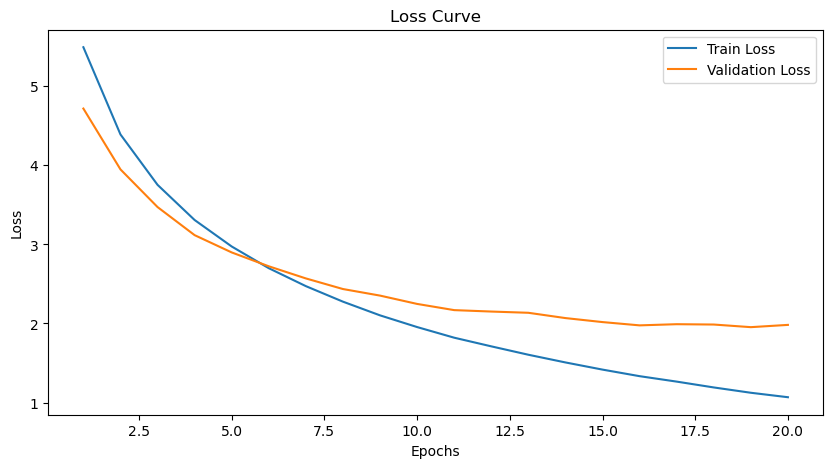

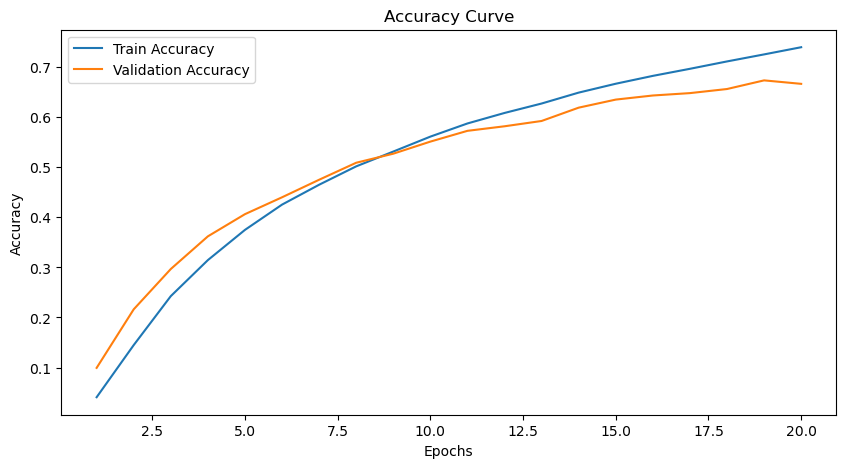

Test Accuracy: 0.6638


In [65]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt


transform = transforms.Compose([
    transforms.Resize((28, 28)),  
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  
])


train_dataset = datasets.ImageFolder(r"C:\Users\arday\.cache\kagglehub\datasets\rajnishe\facescrub-full\preprocessed\train", transform=transform)
val_dataset = datasets.ImageFolder(r"C:\Users\arday\.cache\kagglehub\datasets\rajnishe\facescrub-full\preprocessed\val", transform=transform)
test_dataset = datasets.ImageFolder(r"C:\Users\arday\.cache\kagglehub\datasets\rajnishe\facescrub-full\preprocessed\test", transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)  # Input layer
        self.relu = nn.ReLU() 
        self.fc2 = nn.Linear(hidden_size, num_classes)  # Output layer

    def forward(self, x):
        x = x.view(x.size(0), -1) 
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x


input_size = 28 * 28 * 3  
hidden_size = 300  # Hidden layer siz
num_classes = len(train_dataset.classes)  
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = MLP(input_size=input_size, hidden_size=hidden_size, num_classes=num_classes).to(device)


criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)


epochs = 20
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(epochs):
    model.train()
    train_loss, train_correct = 0, 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_correct += (outputs.argmax(1) == y_batch).sum().item()

    train_losses.append(train_loss / len(train_loader))
    train_accuracies.append(train_correct / len(train_loader.dataset))

 
    model.eval()
    val_loss, val_correct = 0, 0

    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)

            val_loss += loss.item()
            val_correct += (outputs.argmax(1) == y_batch).sum().item()

    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(val_correct / len(val_loader.dataset))

    print(f"Epoch {epoch+1}/{epochs}, "
          f"Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.4f}, "
          f"Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accuracies[-1]:.4f}")


plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs+1), train_losses, label="Train Loss")
plt.plot(range(1, epochs+1), val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss Curve")
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs+1), train_accuracies, label="Train Accuracy")
plt.plot(range(1, epochs+1), val_accuracies, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy Curve")
plt.show()


model.eval()
test_correct = 0

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        outputs = model(X_batch)
        test_correct += (outputs.argmax(1) == y_batch).sum().item()

test_accuracy = test_correct / len(test_loader.dataset)
print(f"Test Accuracy: {test_accuracy:.4f}")


### Part 2.2: AlexNet as a Fixed Feature Extractor
Extract the values of the activations of AlexNet on the face images. Use those as features in order to perform face classification: learn a fully-connected neural network that takes in the activations of the units in the AlexNet layer as inputs, and outputs the name of the person. Below, include a description of the system you built and its performance. It is recommended to start out with only using the `conv4` activations. Using `conv4` is sufficient here.

System Description
I used FaceScrub dataset which contains images of actors faces. I resized all images to 256x256 and then cropped the center region of size 224x224 to alilgn with AlexNet's inout size. I normalized pixels in order with AlexNet's expected distribution:
    -Mean: [0.485,0.456,0.406]
    -SD: [0.229,0.224,0.225]
    
Feature Extraction
I extracted features and labels are saved fır use in training and testing and then I splitted the features into training 80% and testing 20%

Classifier Architecture:
I createad a simple MLP wtih the size of 500 hidden neurons and 12544 input size ( flattened feature size from conv4)
I sued ReLU for activation and used CrossEntropyLoss for loss function 

Training
I used AdamW for optimizer with the learing rate of 0.001 and I looped the training for 10 epochs.
Performance:
Epoch 10/10, Train Loss: 246.1872, Train Acc: 0.8209, Test Acc: 0.6242
The training accuracy is increased dramatically but my test accuracy is degraded. I belive overfitting happened



In [441]:
import torch
from torchvision import models
alexnet = models.alexnet(pretrained=True)
feature_extractor = torch.nn.Sequential(*list(alexnet.features)[:10])  # conv4 is the 10th layer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
feature_extractor = feature_extractor.to(device)


In [442]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np

dataset_dir = r"C:\Users\arday\.cache\kagglehub\datasets\rajnishe\facescrub-full\versions\1\actor_faces"
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load dataset
dataset = datasets.ImageFolder(dataset_dir, transform=transform)
data_loader = DataLoader(dataset, batch_size=32, shuffle=False)

# Extract features
def extract_features(data_loader, model):
    model.eval()
    features, labels = [], []
    with torch.no_grad():
        for images, targets in data_loader:
            images = images.to(device)
            outputs = model(images)  # Extract conv4 features
            outputs = outputs.view(outputs.size(0), -1)  # Flatten features
            features.append(outputs.cpu().numpy())
            labels.append(targets.numpy())
    return np.vstack(features), np.hstack(labels)

features, labels = extract_features(data_loader, feature_extractor)
print(f"Extracted features shape: {features.shape}, Labels shape: {labels.shape}")


Extracted features shape: (23215, 43264), Labels shape: (23215,)


In [4]:
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

train_data = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long))
test_data = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.long))
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)


class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

input_size = features.shape[1]  
hidden_size = 500
num_classes = len(dataset.classes)
mlp_model = MLP(input_size, hidden_size, num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(mlp_model.parameters(), lr=0.001)


def train_mlp(model, train_loader, test_loader, criterion, optimizer, epochs=10):
    for epoch in range(epochs):
        model.train()
        train_loss, train_correct = 0, 0
        
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            train_correct += (outputs.argmax(1) == y_batch).sum().item()
        
        train_acc = train_correct / len(train_loader.dataset)
    
        model.eval()
        test_correct = 0
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                test_correct += (outputs.argmax(1) == y_batch).sum().item()
        
        test_acc = test_correct / len(test_loader.dataset)
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}")

train_mlp(mlp_model, train_loader, test_loader, criterion, optimizer, epochs=10)


Epoch 1/10, Train Loss: 697.6612, Train Acc: 0.6729, Test Acc: 0.6914
Epoch 2/10, Train Loss: 475.5760, Train Acc: 0.6948, Test Acc: 0.6914
Epoch 3/10, Train Loss: 462.6009, Train Acc: 0.6957, Test Acc: 0.6911
Epoch 4/10, Train Loss: 436.0980, Train Acc: 0.6973, Test Acc: 0.6894
Epoch 5/10, Train Loss: 405.0142, Train Acc: 0.7102, Test Acc: 0.6787
Epoch 6/10, Train Loss: 376.3616, Train Acc: 0.7234, Test Acc: 0.6761
Epoch 7/10, Train Loss: 341.5590, Train Acc: 0.7501, Test Acc: 0.6784
Epoch 8/10, Train Loss: 311.7012, Train Acc: 0.7692, Test Acc: 0.5428
Epoch 9/10, Train Loss: 276.9137, Train Acc: 0.8002, Test Acc: 0.5188
Epoch 10/10, Train Loss: 246.1872, Train Acc: 0.8209, Test Acc: 0.6242


### Part 2.3: Visualize Weights
Train two networks the way you did in Part 2.1. Use 300 and 800 hidden units in the hidden layer. Visualize 2 different hidden features (neurons) for each of the two settings, and briefly explain why they are interesting. A sample visualization of a hidden feature is shown below. Note that you probably need to use L2 regularization while training to obtain nice weight visualizations.

![](figures/figure2.jpg)

<h1>300 hidden layer</h1>

Epoch 1/20, Train Loss: 5.4683, Train Acc: 0.0438, Val Loss: 4.6469, Val Acc: 0.1060
Epoch 2/20, Train Loss: 4.3231, Train Acc: 0.1553, Val Loss: 3.8546, Val Acc: 0.2278
Epoch 3/20, Train Loss: 3.6821, Train Acc: 0.2556, Val Loss: 3.4027, Val Acc: 0.3143
Epoch 4/20, Train Loss: 3.2512, Train Acc: 0.3287, Val Loss: 3.0851, Val Acc: 0.3746
Epoch 5/20, Train Loss: 2.9233, Train Acc: 0.3868, Val Loss: 2.8168, Val Acc: 0.4250
Epoch 6/20, Train Loss: 2.6668, Train Acc: 0.4322, Val Loss: 2.6869, Val Acc: 0.4485
Epoch 7/20, Train Loss: 2.4500, Train Acc: 0.4710, Val Loss: 2.5228, Val Acc: 0.4829
Epoch 8/20, Train Loss: 2.2639, Train Acc: 0.5078, Val Loss: 2.3907, Val Acc: 0.5197
Epoch 9/20, Train Loss: 2.0941, Train Acc: 0.5358, Val Loss: 2.2882, Val Acc: 0.5465
Epoch 10/20, Train Loss: 1.9529, Train Acc: 0.5646, Val Loss: 2.2063, Val Acc: 0.5598
Epoch 11/20, Train Loss: 1.8263, Train Acc: 0.5854, Val Loss: 2.1617, Val Acc: 0.5821
Epoch 12/20, Train Loss: 1.7055, Train Acc: 0.6106, Val Loss: 2

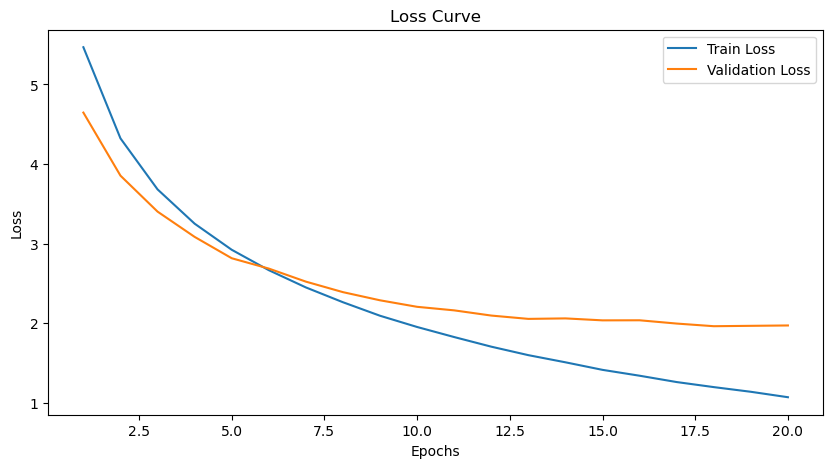

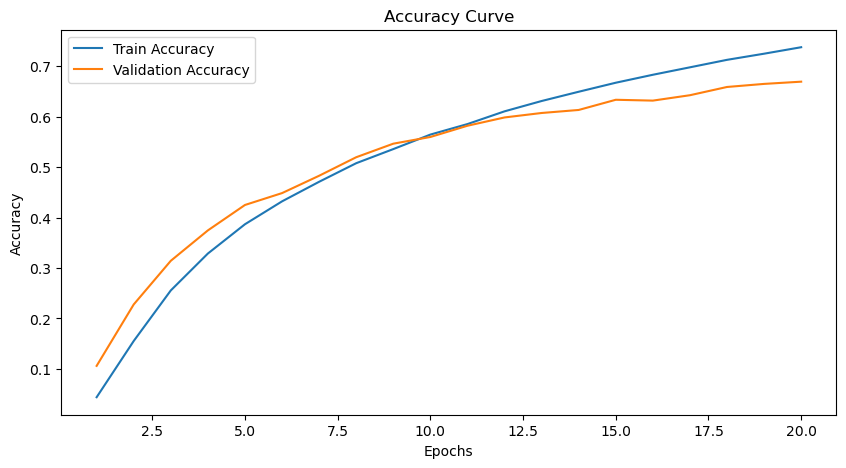

Test Accuracy: 0.6623


In [144]:
# This is the neural network and trainig for 300 hidden layer
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt


transform = transforms.Compose([
    transforms.Resize((28, 28)),  
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  
])


train_dataset = datasets.ImageFolder(r"C:\Users\arday\.cache\kagglehub\datasets\rajnishe\facescrub-full\preprocessed\train", transform=transform)
val_dataset = datasets.ImageFolder(r"C:\Users\arday\.cache\kagglehub\datasets\rajnishe\facescrub-full\preprocessed\val", transform=transform)
test_dataset = datasets.ImageFolder(r"C:\Users\arday\.cache\kagglehub\datasets\rajnishe\facescrub-full\preprocessed\test", transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size) 
        self.relu = nn.ReLU()  
        self.fc2 = nn.Linear(hidden_size, num_classes)  

    def forward(self, x):
        x = x.view(x.size(0), -1) 
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

input_size = 28 * 28 * 3  
hidden_size = 300 
num_classes = len(train_dataset.classes) 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = MLP(input_size=input_size, hidden_size=hidden_size, num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)

epochs = 20
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(epochs):
    model.train()
    train_loss, train_correct = 0, 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_correct += (outputs.argmax(1) == y_batch).sum().item()

    train_losses.append(train_loss / len(train_loader))
    train_accuracies.append(train_correct / len(train_loader.dataset))

    # Validation loop
    model.eval()
    val_loss, val_correct = 0, 0

    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)

            val_loss += loss.item()
            val_correct += (outputs.argmax(1) == y_batch).sum().item()

    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(val_correct / len(val_loader.dataset))

    print(f"Epoch {epoch+1}/{epochs}, "
          f"Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.4f}, "
          f"Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accuracies[-1]:.4f}")

plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs+1), train_losses, label="Train Loss")
plt.plot(range(1, epochs+1), val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss Curve")
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs+1), train_accuracies, label="Train Accuracy")
plt.plot(range(1, epochs+1), val_accuracies, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy Curve")
plt.show()

model.eval()
test_correct = 0

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        outputs = model(X_batch)
        test_correct += (outputs.argmax(1) == y_batch).sum().item()

test_accuracy = test_correct / len(test_loader.dataset)
print(f"Test Accuracy: {test_accuracy:.4f}")


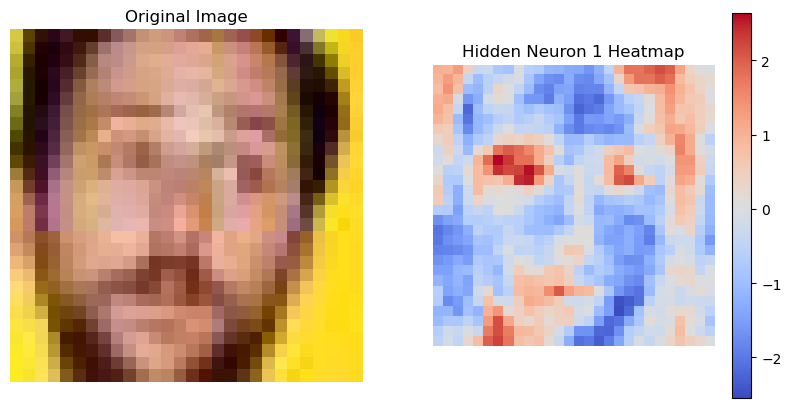

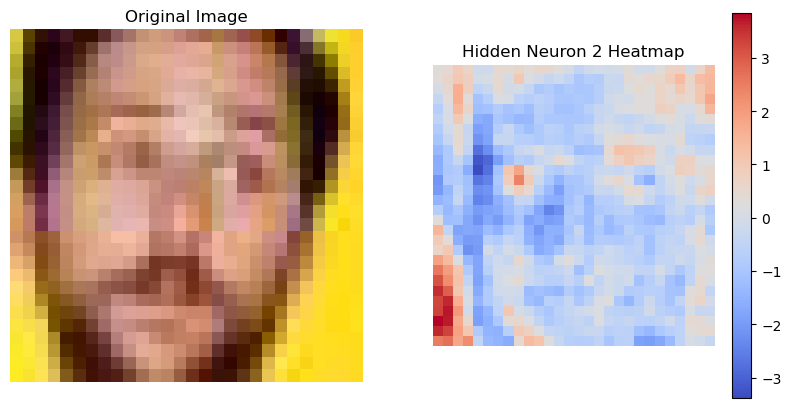

In [145]:

def visualize_hidden_weights_with_image(model, hidden_size, input_shape, num_neurons=2, data_loader=None):

    weights = model.fc1.weight.data.cpu().numpy()
    
 
    if data_loader is not None:
        data_iter = iter(data_loader)
        original_images, _ = next(data_iter)
        original_images = original_images.cpu().numpy()
    else:
        raise ValueError("Data loader cannot be None for displaying original images.")

    for i in range(num_neurons):
        neuron_weights = weights[i].reshape(input_shape)  
        neuron_weights_normalized = (neuron_weights - neuron_weights.mean()) / neuron_weights.std()  # Normalize

        plt.figure(figsize=(10, 5))

    
        plt.subplot(1, 2, 1)
        original_image = np.transpose(original_images[0], (1, 2, 0))  
        plt.imshow((original_image * 0.5 + 0.5)) 
        plt.title("Original Image")
        plt.axis("off")

        plt.subplot(1, 2, 2)
        plt.imshow(neuron_weights_normalized[0], cmap="coolwarm", interpolation="nearest")
        plt.colorbar()
        plt.title(f"Hidden Neuron {i+1} Heatmap")
        plt.axis("off")

        plt.show()

input_shape = (3, 28, 28)  # 28x28x3 input images
visualize_hidden_weights_with_image(
    model, 
    hidden_size=hidden_size, 
    input_shape=input_shape, 
    num_neurons=2, 
    data_loader=train_loader 
)


<h1>800 hidden layer</h1>

Epoch 1/20, Train Loss: 5.4447, Train Acc: 0.0449, Val Loss: 4.6174, Val Acc: 0.1118
Epoch 2/20, Train Loss: 4.3091, Train Acc: 0.1576, Val Loss: 3.8751, Val Acc: 0.2247
Epoch 3/20, Train Loss: 3.6436, Train Acc: 0.2630, Val Loss: 3.3553, Val Acc: 0.3196
Epoch 4/20, Train Loss: 3.1823, Train Acc: 0.3391, Val Loss: 3.0536, Val Acc: 0.3817
Epoch 5/20, Train Loss: 2.8406, Train Acc: 0.4017, Val Loss: 2.8275, Val Acc: 0.4288
Epoch 6/20, Train Loss: 2.5632, Train Acc: 0.4544, Val Loss: 2.6221, Val Acc: 0.4693
Epoch 7/20, Train Loss: 2.3162, Train Acc: 0.4957, Val Loss: 2.4230, Val Acc: 0.5165
Epoch 8/20, Train Loss: 2.1007, Train Acc: 0.5329, Val Loss: 2.3541, Val Acc: 0.5369
Epoch 9/20, Train Loss: 1.9305, Train Acc: 0.5685, Val Loss: 2.1949, Val Acc: 0.5727
Epoch 10/20, Train Loss: 1.7739, Train Acc: 0.5963, Val Loss: 2.1589, Val Acc: 0.5865
Epoch 11/20, Train Loss: 1.6355, Train Acc: 0.6238, Val Loss: 2.1272, Val Acc: 0.5964
Epoch 12/20, Train Loss: 1.4952, Train Acc: 0.6529, Val Loss: 2

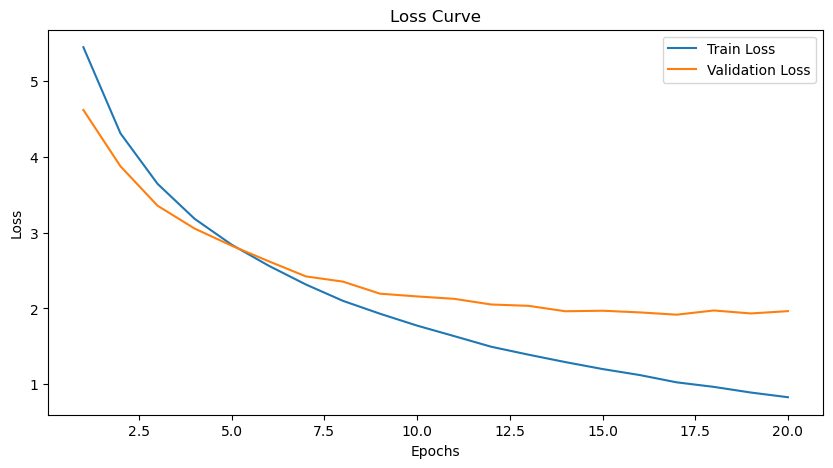

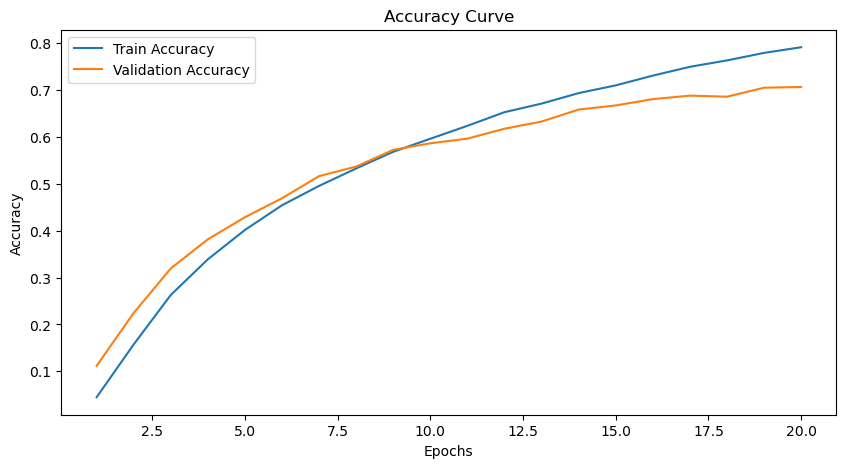

Test Accuracy: 0.7044


In [13]:
##for hidden layer=800
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

transform = transforms.Compose([
    transforms.Resize((28, 28)),  
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  
])


train_dataset = datasets.ImageFolder(r"C:\Users\arday\.cache\kagglehub\datasets\rajnishe\facescrub-full\preprocessed\train", transform=transform)
val_dataset = datasets.ImageFolder(r"C:\Users\arday\.cache\kagglehub\datasets\rajnishe\facescrub-full\preprocessed\val", transform=transform)
test_dataset = datasets.ImageFolder(r"C:\Users\arday\.cache\kagglehub\datasets\rajnishe\facescrub-full\preprocessed\test", transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)  
        self.relu = nn.ReLU() 
        self.fc2 = nn.Linear(hidden_size, num_classes)  

    def forward(self, x):
        x = x.view(x.size(0), -1) 
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

input_size = 28 * 28 * 3  
hidden_size = 800 
num_classes = len(train_dataset.classes) 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = MLP(input_size=input_size, hidden_size=hidden_size, num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)

epochs = 20
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(epochs):
    model.train()
    train_loss, train_correct = 0, 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_correct += (outputs.argmax(1) == y_batch).sum().item()

    train_losses.append(train_loss / len(train_loader))
    train_accuracies.append(train_correct / len(train_loader.dataset))

    model.eval()
    val_loss, val_correct = 0, 0

    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)

            val_loss += loss.item()
            val_correct += (outputs.argmax(1) == y_batch).sum().item()

    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(val_correct / len(val_loader.dataset))

    print(f"Epoch {epoch+1}/{epochs}, "
          f"Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.4f}, "
          f"Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accuracies[-1]:.4f}")

plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs+1), train_losses, label="Train Loss")
plt.plot(range(1, epochs+1), val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss Curve")
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs+1), train_accuracies, label="Train Accuracy")
plt.plot(range(1, epochs+1), val_accuracies, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy Curve")
plt.show()

model.eval()
test_correct = 0

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        outputs = model(X_batch)
        test_correct += (outputs.argmax(1) == y_batch).sum().item()

test_accuracy = test_correct / len(test_loader.dataset)
print(f"Test Accuracy: {test_accuracy:.4f}")


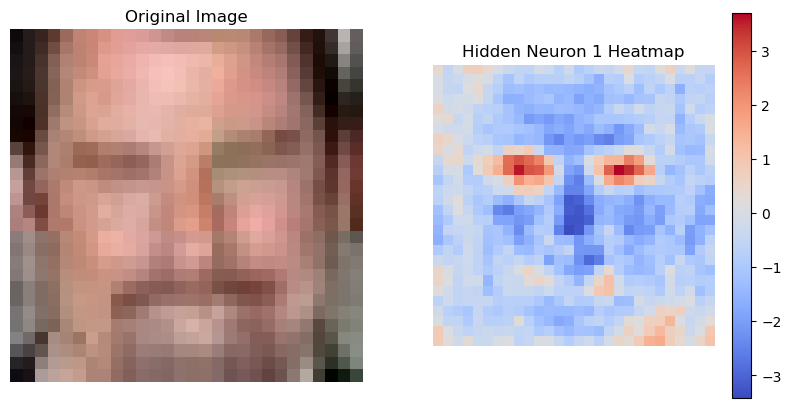

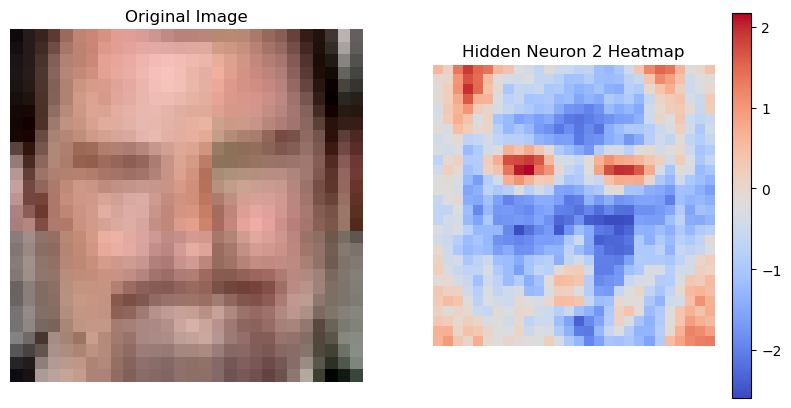

In [16]:

def visualize_hidden_weights_with_image(model, hidden_size, input_shape, num_neurons=2, data_loader=None):
    # Extract weights from fc1
    weights = model.fc1.weight.data.cpu().numpy()

    if data_loader is not None:
        data_iter = iter(data_loader)
        original_images, _ = next(data_iter)
        original_images = original_images.cpu().numpy()
    else:
        raise ValueError("Data loader cannot be None for displaying original images.")

    for i in range(num_neurons):
        neuron_weights = weights[i].reshape(input_shape)  # Reshape to input dimensions
        neuron_weights_normalized = (neuron_weights - neuron_weights.mean()) / neuron_weights.std()  # Normalize

        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        original_image = np.transpose(original_images[0], (1, 2, 0))  
        plt.imshow((original_image * 0.5 + 0.5))  
        plt.title("Original Image")
        plt.axis("off")

        # Plot weight heatmap
        plt.subplot(1, 2, 2)
        plt.imshow(neuron_weights_normalized[0], cmap="coolwarm", interpolation="nearest")
        plt.colorbar()
        plt.title(f"Hidden Neuron {i+1} Heatmap")
        plt.axis("off")

        plt.show()

input_shape = (3, 28, 28)  # 28x28x3 input images
visualize_hidden_weights_with_image(
    model, 
    hidden_size=hidden_size, 
    input_shape=input_shape, 
    num_neurons=2, 
    data_loader=train_loader 
)


In the number of 800 hidden layers, it can be seen that the heat map is detecting features much better. In the first picture, I think the feature that detected is eyes and second part is probably about the eyes and black parts like hair and beards

### Part 2.4: Finetuning AlexNet
Train two networks the way you did in Part 2.1. Use 300 and 800 hidden units in the hidden layer. Visualize 2 different hidden features (neurons) for each of the two settings, and briefly explain why they are interesting. A sample visualization of a hidden feature is shown in Figure 4. Note that you probably need to use L2 regularization while training to obtain nice weight visualizations.


Using device: cuda
Epoch 1/10, Train Loss: 3105.8561, Train Acc: 0.0671, Val Loss: 671.1539, Val Acc: 0.2230
Epoch 2/10, Train Loss: 1899.9369, Train Acc: 0.3083, Val Loss: 416.0366, Val Acc: 0.4904
Epoch 3/10, Train Loss: 1235.0856, Train Acc: 0.5133, Val Loss: 315.9500, Val Acc: 0.6080
Epoch 4/10, Train Loss: 816.2525, Train Acc: 0.6610, Val Loss: 236.7492, Val Acc: 0.6957
Epoch 5/10, Train Loss: 545.1565, Train Acc: 0.7600, Val Loss: 202.4737, Val Acc: 0.7403
Epoch 6/10, Train Loss: 363.2375, Train Acc: 0.8324, Val Loss: 184.1512, Val Acc: 0.7636
Epoch 7/10, Train Loss: 243.7073, Train Acc: 0.8830, Val Loss: 182.4727, Val Acc: 0.7720
Epoch 8/10, Train Loss: 188.1090, Train Acc: 0.9084, Val Loss: 174.7822, Val Acc: 0.7837
Epoch 9/10, Train Loss: 158.9183, Train Acc: 0.9214, Val Loss: 163.7066, Val Acc: 0.8023
Epoch 10/10, Train Loss: 131.1065, Train Acc: 0.9328, Val Loss: 163.6149, Val Acc: 0.8113


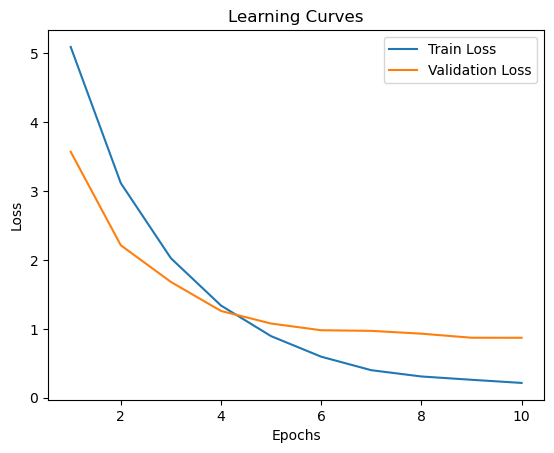

Test Accuracy: 0.8061


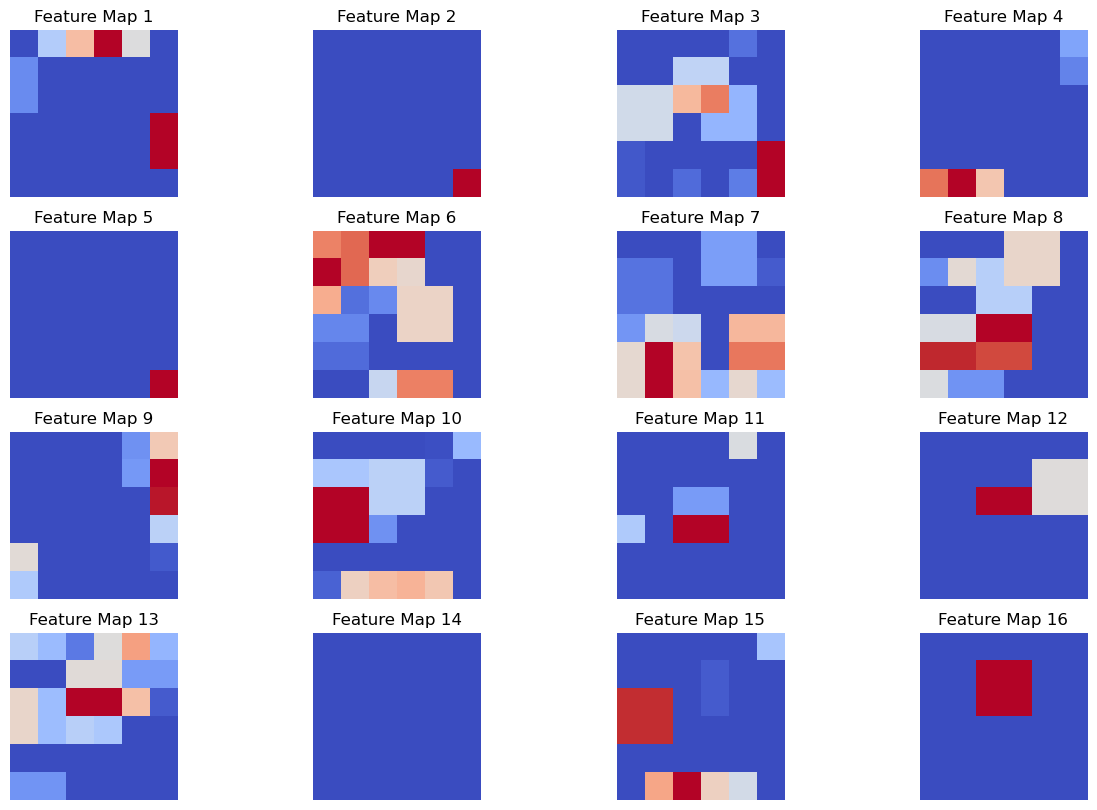

In [79]:
# training for alexnet model
import torchvision.models as models
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
transform = transforms.Compose([
    transforms.Resize((224, 224)), 
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # ImageNet normalization
])

train_dataset = datasets.ImageFolder(r"C:\Users\arday\.cache\kagglehub\datasets\rajnishe\facescrub-full\preprocessed\train", transform=transform)
val_dataset = datasets.ImageFolder(r"C:\Users\arday\.cache\kagglehub\datasets\rajnishe\facescrub-full\preprocessed\val", transform=transform)
test_dataset = datasets.ImageFolder(r"C:\Users\arday\.cache\kagglehub\datasets\rajnishe\facescrub-full\preprocessed\test", transform=transform)


train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

model = models.alexnet(pretrained=True)
num_classes = len(train_dataset.classes)

model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)
model = model.to(device) 

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0001)

# **5. Training function**
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10):
    train_losses, val_losses = [], []
    for epoch in range(epochs):
        model.train()
        train_loss, train_correct = 0, 0
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)  
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            train_correct += (outputs.argmax(1) == labels).sum().item()
        
        train_losses.append(train_loss / len(train_loader))
        train_acc = train_correct / len(train_loader.dataset)
        
        model.eval()
        val_loss, val_correct = 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)  
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                val_correct += (outputs.argmax(1) == labels).sum().item()
        
        val_losses.append(val_loss / len(val_loader))
        val_acc = val_correct / len(val_loader.dataset)
        
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
    
    return train_losses, val_losses

epochs = 10
train_losses, val_losses = train_model(model, train_loader, val_loader, criterion, optimizer, epochs)

plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Learning Curves')
plt.show()

def evaluate_model(model, test_loader):
    model.eval()
    test_correct = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device) 
            outputs = model(images)
            test_correct += (outputs.argmax(1) == labels).sum().item()
    
    test_acc = test_correct / len(test_loader.dataset)
    print(f"Test Accuracy: {test_acc:.4f}")
    
    return test_acc

test_accuracy = evaluate_model(model, test_loader)

def visualize_feature_maps(model, image):
    model.eval()
    feature_extractor = model.features  
    with torch.no_grad():
        features = feature_extractor(image.unsqueeze(0).to(device)) 
        features = features.squeeze(0).cpu().numpy()  
    
    plt.figure(figsize=(15, 10))
    for i in range(min(features.shape[0], 16)):  
        plt.subplot(4, 4, i+1)
        plt.imshow(features[i], cmap="coolwarm", interpolation="nearest")
        plt.axis("off")
        plt.title(f"Feature Map {i+1}")
    plt.show()

sample_image, _ = test_dataset[0]  
visualize_feature_maps(model, sample_image)


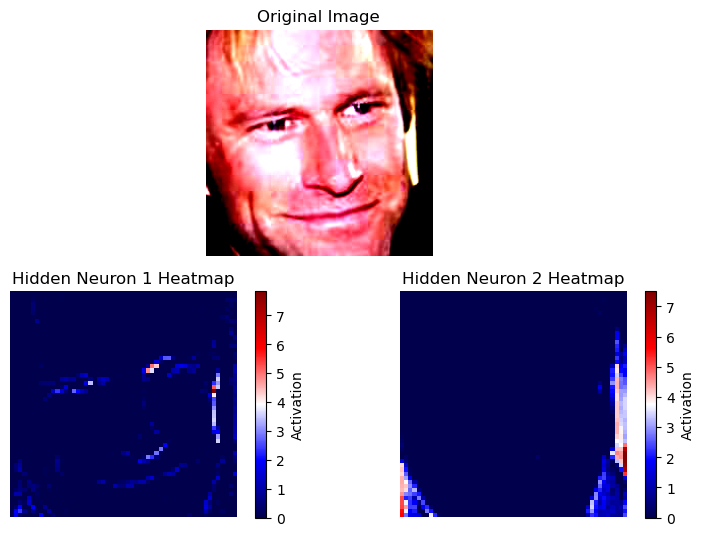

In [90]:
import matplotlib.pyplot as plt
import numpy as np

# Function to visualize original image along with feature maps and heatmaps
def visualize_with_original_image(model, dataloader, layer_name, num_features=2):
    features = {}

    def hook(module, input, output):
        features[layer_name] = output
    layer = dict([*model.named_modules()])[layer_name]
    hook_handle = layer.register_forward_hook(hook)
    model.eval()
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            model(images)  
            original_image = images[0].cpu().numpy() h
            break 
    hook_handle.remove()

    original_image = np.transpose(original_image, (1, 2, 0))  
    original_image = np.clip(original_image, 0, 1) 

    plt.figure(figsize=(8, 8))

    plt.subplot(3, 1, 1)
    plt.imshow(original_image)
    plt.title("Original Image")
    plt.axis("off")

    feature_maps = features[layer_name].cpu().numpy()
    for i in range(num_features):
        feature_map = feature_maps[0, i] 
        plt.subplot(3, num_features, num_features + i + 1)
        plt.imshow(feature_map, cmap="seismic", interpolation="nearest")
        plt.colorbar(label="Activation")
        plt.title(f"Hidden Neuron {i+1} Heatmap")
        plt.axis("off")

    plt.tight_layout()
    plt.show()
visualize_with_original_image(model, test_loader, layer_name="features.0", num_features=2)


In the alexnet's visulaztion, 2 different features are detected. I believe that first feature is edges of the image and second is vertical edges

In [110]:
torch.save(model.state_dict(), "mlp_trained.pth")


### Part 2.5: Bonus: Gradient Visualization
Here, you will use [Utku Ozbulak’s PyTorch CNN Visualizations Library](https://github.com/utkuozbulak/pytorch-cnn-visualizations/) to visualize the important parts of the input image for a particular output class. In particular, just select a specific picture of an actor, and then using your trained network in Part 2.4, perform Gradient visualization with guided backpropagation to understand the prediction for that actor with respect to the input image. Comment on your results.

In [103]:
pip install torch torchvision matplotlib numpy


Note: you may need to restart the kernel to use updated packages.


## What to Turn In
You have two options for submission:
1) Provide all the relevant answers to questions, images, figures, etc, in this Jupyter notebook, convert the jupyter notebook into a PDF, and upload the PDF.
2) Write all the answers to the questions and any relevant figures in a LaTeX report, convert the report to a PDF, and upload a zip file containing both the jupyter notebook and the report. 

## Grading
The assignment will be graded out of `100` points: `0` (no submission), `20` (an attempt at a solution), `40` (a partially correct solution), `60` (a mostly correct solution), `80` (a correct solution), `100` (a particularly creative or insightful solution). The grading depends on both the content and clarity of your report.